In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision


import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display as ipy_display, clear_output

/home1/ruitongs/.conda/envs/UDA/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
deplabv3 = __import__('Deeplabv3')
import networks

In [3]:
import dataset

# parameters

In [4]:
num_classes = 5
batch_size = 36
suffix = '70000'
continue_run = True

# CUDA

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Path

In [6]:
source_mr_train_dir = "../data/h5py/"
source_mr_test_dir = "../data/h5py/"

# sample from dataset

In [7]:
def sample_batch(dataset, batch_size=20, seed=None):
    if seed is not None:
        np.random.seed(seed)
    
    data_dir = dataset.data_dir
    num_samples = len(dataset)
    sample_indices = np.random.choice(num_samples, batch_size, replace=True) # replace=True allow repeat

    images = []
    labels = []

    for idx in sample_indices:
        
        data_vol, label_vol = dataset[idx]
        
        images.append(data_vol)
        labels.append(label_vol)

    images = torch.stack(images)
    labels = torch.stack(labels)

    return images, labels

# Loss

In [8]:
# https://gist.github.com/yang-zhang/217dcc6ae9171d7a46ce42e215c1fee0
def masked_ce_loss(num_classes=20, class_to_ignore=None):
    mask = np.ones(num_classes)
    if class_to_ignore is not None:
        mask[class_to_ignore] = 0
    mask = torch.tensor(mask, dtype=torch.float32)

    def masked_loss(y_pred, y_true, from_logits = False, F_corss_entropy_label = True):

        # Preprocess data
        if not from_logits and not F_corss_entropy_label: # False = (True and False) if I want to use F_corss_entropy_label
            print('wrong')
            y_pred = F.softmax(y_pred, dim=1)
        
        if F_corss_entropy_label:
            
            loss = F.cross_entropy(y_pred, y_true, weight = mask.to(y_true.device) , reduction='mean')

            # For cross entropy: y_pred has the shape [batch_size, num_classes, height, width]
            #                    y_true has the shape [batch_size, height, width].

            #The F.cross_entropy function understands this difference in dimensions and 
            #calculates the loss accordingly by comparing the predicted class probabilities 
            #(y_pred) to the ground truth class indices (y_true).
            
        else:
            # not sucess for manually implement don't know why
            # Clip y_pred values to avoid numerical instability
            y_pred = torch.clamp(y_pred, 1e-10, 1)

            # Move mask tensor to the same device as y_true; input need to be (batch, height, weight), channel = 1 squeezed before
            y_true_one_hot  = F.one_hot(y_true, num_classes=num_classes).permute(0, 3, 1, 2)

            # (8, 5, 256, 256) * Shape: (1, 5, 1, 1)
            y_true_one_hot_masked = y_true_one_hot  * mask.to(y_true.device).unsqueeze(0).unsqueeze(-1).unsqueeze(-1)  



            # Calculate cross entropy loss for each class
            ce_loss = -y_true_one_hot_masked * torch.log(y_pred)

            # Sum the loss for each class and take the mean over the batch
            loss = ce_loss.sum(dim=[1, 2, 3]).mean()

        return loss

    return masked_loss

# Initialize

In [9]:
dataloader = dataset.get_dataloader( source_mr_train_dir,  source_mr_test_dir, num_classes, batch_size )

train_dataset = dataloader["train"].dataset
test_dataset = dataloader["test"].dataset

In [10]:
dpv3 = deplabv3.DeepLabV3(num_classes)
classifier = networks.classifier(num_classes)

dpv3 = dpv3.to(device)
classifier = classifier.to(device)

# parallel
dpv3 = torch.nn.DataParallel(dpv3)
classifier = torch.nn.DataParallel(classifier)

In [11]:
loss_function = masked_ce_loss(num_classes, None)  

optimizer_dpv3 = torch.optim.Adam(dpv3.parameters(), lr=1e-4, eps=1e-6, weight_decay=1e-6)
optimizer_classifier = torch.optim.Adam(classifier.parameters(), lr=1e-4, eps=1e-6, weight_decay=1e-6)

In [12]:
if continue_run:
    
    dpv3_checkpoint = torch.load('./record-data/' + 'dpv3_weights_' + suffix + '.pth')
    classifier_checkpoint = torch.load('./record-data/' + 'classifier_weights_' + suffix + '.pth')

    dpv3.load_state_dict(dpv3_checkpoint)
    classifier.load_state_dict(classifier_checkpoint)
    print("Loaded model weights")

Loaded model weights


# Training

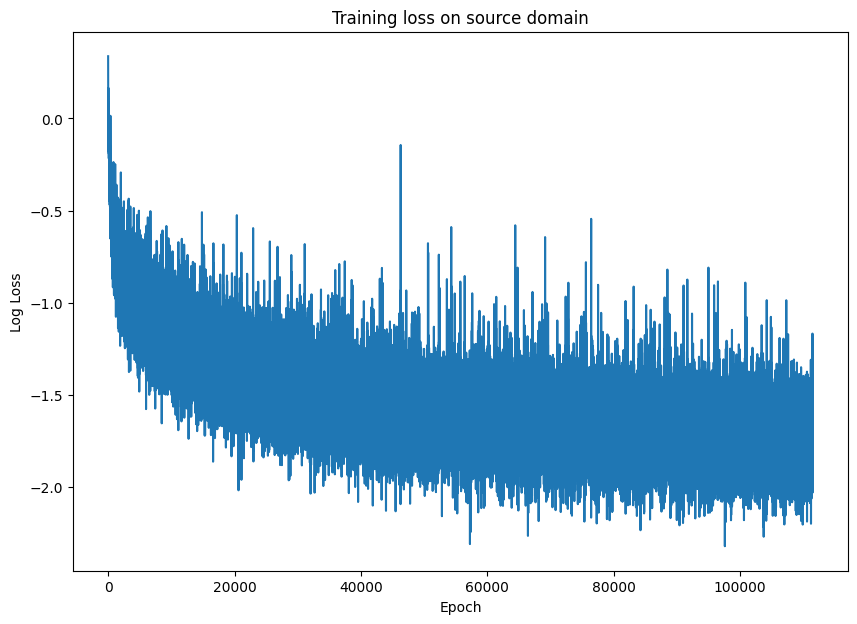

Epoch: 111502/600000, Loss: 0.2383
Epoch: 111503/600000, Loss: 0.1747
Epoch: 111504/600000, Loss: 0.2094
Epoch: 111505/600000, Loss: 0.1674
Epoch: 111506/600000, Loss: 0.1925
Epoch: 111507/600000, Loss: 0.1816
Epoch: 111508/600000, Loss: 0.1913
Epoch: 111509/600000, Loss: 0.1908
Epoch: 111510/600000, Loss: 0.2097
Epoch: 111511/600000, Loss: 0.2166
Epoch: 111512/600000, Loss: 0.1862
Epoch: 111513/600000, Loss: 0.1911
Epoch: 111514/600000, Loss: 0.1733
Epoch: 111515/600000, Loss: 0.2529
Epoch: 111516/600000, Loss: 0.2011
Epoch: 111517/600000, Loss: 0.2001
Epoch: 111518/600000, Loss: 0.2081
Epoch: 111519/600000, Loss: 0.1912
Epoch: 111520/600000, Loss: 0.1866
Epoch: 111521/600000, Loss: 0.1570
Epoch: 111522/600000, Loss: 0.2265
Epoch: 111523/600000, Loss: 0.2103
Epoch: 111524/600000, Loss: 0.2334
Epoch: 111525/600000, Loss: 0.1539
Epoch: 111526/600000, Loss: 0.2359
Epoch: 111527/600000, Loss: 0.2025
Epoch: 111528/600000, Loss: 0.1846
Epoch: 111529/600000, Loss: 0.1986
Epoch: 111530/600000

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home1/ruitongs/.conda/envs/UDA/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/SLURM_16837550/ipykernel_4996/902715452.py", line 22, in <module>
    source_train_data, source_train_labels = sample_batch(train_dataset, batch_size, seed=epoch)
  File "/tmp/SLURM_16837550/ipykernel_4996/2579745423.py", line 14, in sample_batch
    data_vol, label_vol = dataset[idx]
  File "/project/rostamim_919/ruitongs/3D-UDA-(MM-WHS-data)-(source-ct)/Deeplabv3-2(BN)/dataset.py", line 175, in __getitem__
    data_vol, label_vol = self.transform(data_vol, label_vol)
  File "/project/rostamim_919/ruitongs/3D-UDA-(MM-WHS-data)-(source-ct)/Deeplabv3-2(BN)/dataset.py", line 129, in __call__
    volume, label = self.random_scale(volume, label)
  File "/project/rostamim_919/ruitongs/3D-UDA-(MM-WHS-data)-(source-ct)/Deeplabv3-2(BN)/dataset.py", line 106, in random_s

TypeError: object of type 'NoneType' has no len()

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f4c4017ee60> (for post_execute):


KeyboardInterrupt: 

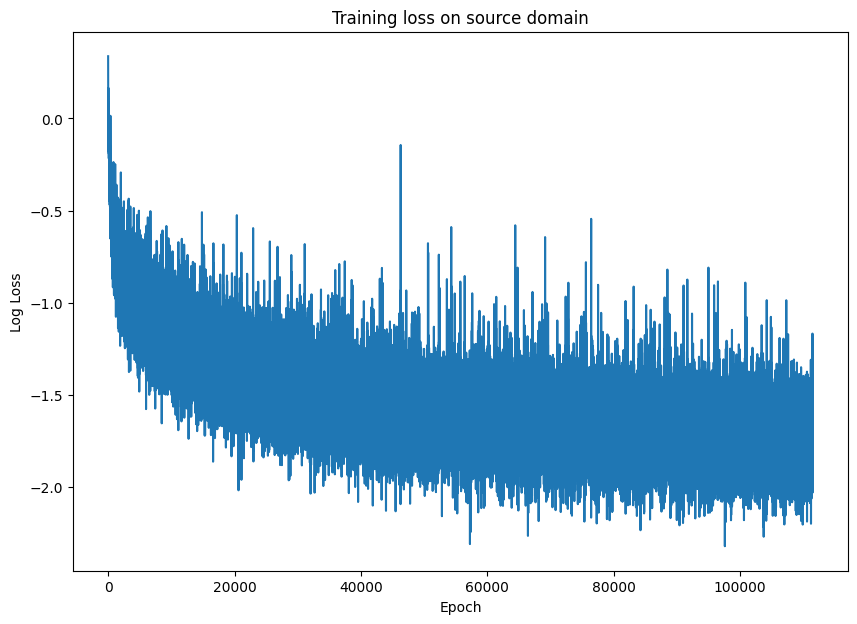

In [13]:
restart_epoch = 0
epochs = 600000
epoch_step = 250

fig, ax = plt.subplots(1, figsize=(10, 7))

if continue_run:
    with open('record-data/' + "loss_history" + "_" + suffix + ".pkl", "rb") as file:
        loss_history = pickle.load(file)
        
    restart_epoch = len(loss_history)
    
else:
    loss_history = []

start_time = time.time()

for epoch in range(restart_epoch, epochs):
    
    dpv3.train()
    
    source_train_data, source_train_labels = sample_batch(train_dataset, batch_size, seed=epoch)
    
    source_train_data = source_train_data.to(device)
    source_train_labels = source_train_labels.to(device)
    
    # zero grad
    optimizer_dpv3.zero_grad()
    optimizer_classifier.zero_grad()
    
    # predicts
    outputs = dpv3(source_train_data) # batch_size, num_classes = 5, 32 = D, 256 = H, 256 = W
    outputs = classifier(outputs) 
    
    # Loss 
    loss = loss_function(outputs, source_train_labels)
    loss.backward()
    
    # step
    optimizer_dpv3.step()
    optimizer_classifier.step()
    
    loss_history.append(loss.item())
    print(f"Epoch: {epoch+1}/{epochs}, Loss: {loss.item():.4f}")
    
    
    if epoch % epoch_step == 0 or epoch < 1000:
        if epoch != 0:
            ax.clear()
            ax.plot(np.log(np.asarray(loss_history))) #not understand why do np.log； <1 will negative

        ax.set_title("Training loss on source domain")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Log Loss")

        clear_output(wait=True)  # Add this line to clear the output
        ipy_display(plt.gcf())  # Use the new name for the display function
        time.sleep(1e-3)  # Add a small delay for smoother updates
        
        
    
    if epoch % 10000 == 0 or epoch == epochs - 1:
        
        torch.save(dpv3.state_dict(), 'record-data/' + 'dpv3_weights' + "_" + str(epoch) + '.pth')
        torch.save(classifier.state_dict(),'record-data/' + 'classifier_weights' + "_" + str(epoch) + '.pth')
        
        with open('record-data/' + "loss_history" + "_" + str(epoch) + ".pkl", "wb") as file:
            pickle.dump(loss_history, file)

In [ ]:
torch.save(dpv3.state_dict(), 'record-data/' + 'dpv3_weights' + "_" + str(epoch) + '.pth')
torch.save(classifier.state_dict(),'record-data/' + 'classifier_weights' + "_" + str(epoch) + '.pth')

with open('record-data/' + "loss_history" + "_" + str(epoch) + ".pkl", "wb") as file:
    pickle.dump(loss_history, file)